In [1]:
import numpy as np
from scipy.stats import spearmanr
from scipy import sparse
import cmath
from sklearn.decomposition import PCA
import sys, os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm
import matplotlib.patches as patches




sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')
from futils import read_metrics_filepath, extract_weights, data2percentile, get_hilbert, get_phases, get_synch, jthreshold
from futils import ensemble_detection

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

In [167]:
FISH_ID = 5
data_filepath = '../data/fish-%d-processed-2.npz' % FISH_ID
f = np.load(data_filepath)
traces = f['traces']
coords          = f['coords']
S               = f['S']
f.close()
print(S.shape)

complete_times = np.arange(0, traces.shape[1]) * 0.5
dynamic_times  = complete_times[120:]

presz_start_idx = 500
sz_start_idx = 2190
#fish 2 - 1370
#fish 3 - 1270
#fish 5 - 2190
#fish 6 - 1360

from modeling_analysis_utils import load_neurons
traces_full_filepath         = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID
mask_filepath                = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID

###
_, all_spatial_coords        = load_neurons(mask_filepath, region_name=['Telencephalon -', 
                                                                         'Mesencephalon -', 
                                                                         'Diencephalon -', 
                                                                         'Rhombencephalon -',], extend=True)
all_spatial_coords = np.asarray(all_spatial_coords, dtype='float32')

_, dthalamus_spatial_coords  = load_neurons(mask_filepath, region_name='Diencephalon - Dorsal Thalamus')
_, vthalamus_spatial_coords = load_neurons(mask_filepath, region_name='Diencephalon - Ventral Thalamus')

_, cerebellum_spatial_coords = load_neurons(mask_filepath, region_name='Rhombencephalon - Cerebellum')
_, hypothalamus_spatial_coords   = load_neurons(mask_filepath, region_name='Diencephalon - Intermediate Hypothalamus')
                                                                        
_, preoptic_spatial_coords  = load_neurons(mask_filepath,region_name='Diencephalon - Preoptic Area')
_, tectum_spatial_coords    = load_neurons(mask_filepath, region_name='Mesencephalon - Tectum Stratum Periventriculare')
_, habenula_spatial_coords = load_neurons(mask_filepath, region_name='Diencephalon - Habenula')


(4894, 4894)


In [168]:
## Extract graph metrics

metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%d-weighted/graph-metrics' % FISH_ID


nmatrices=2380
dynamic_degree_centrality, dynamic_eigenvector_centrality, dynamic_clustering_coefficient = read_metrics_filepath(metrics_filepath, nmatrices, [], verbose=True)
dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality_percentile, dynamic_cc_percentile  = [], [], []
method = 'average'

for i in range(len(dynamic_degree_centrality)):
    dynamic_degree_centrality_percentile.append(data2percentile(dynamic_degree_centrality[i], method=method))
    dynamic_eigenvector_centrality_percentile.append(data2percentile(dynamic_eigenvector_centrality[i], method=method))
    dynamic_cc_percentile.append(data2percentile(dynamic_clustering_coefficient[i], method=method))
dynamic_degree_centrality_percentile      = np.asarray(dynamic_degree_centrality_percentile, dtype='float32')
dynamic_eigenvector_centrality_percentile = np.asarray(dynamic_eigenvector_centrality_percentile, dtype='float32')
dynamic_cc_percentile = np.asarray(dynamic_cc_percentile, dtype='float32')

dynamic_ev_deg_correlation = []
for i in range(len(dynamic_degree_centrality_percentile)):
    deg = dynamic_degree_centrality_percentile[i]
    ev  = dynamic_eigenvector_centrality_percentile[i]
    
    rho, _ = spearmanr(deg, ev)
    dynamic_ev_deg_correlation.append(rho)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [31]:
fig, ax = plt.subplots()
ax.plot(dynamic_times, dynamic_ev_deg_correlation, color='r')
ax2 = ax.twinx()
ax2.plot(complete_times, np.mean(traces, axis=0), color='k')
plt.show()

plt.figure()

plt.hist(dynamic_degree_centrality[0], rwidth=0.65, color='k')
plt.hist(dynamic_degree_centrality[sz_start_idx-100], rwidth=0.65, color='r')
plt.show()

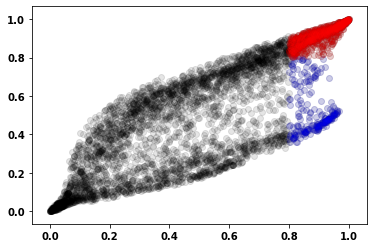

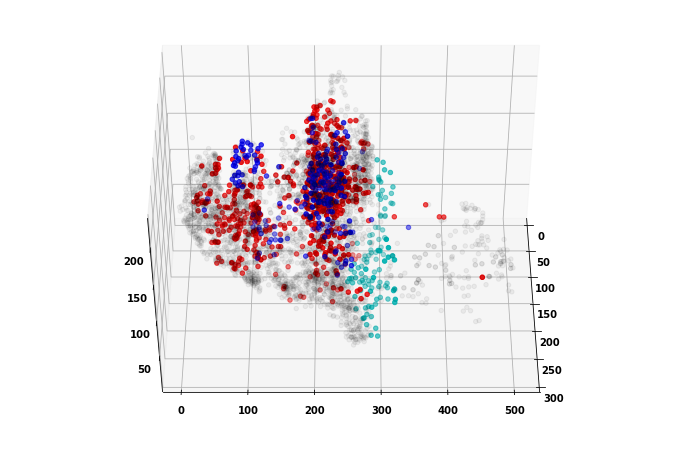

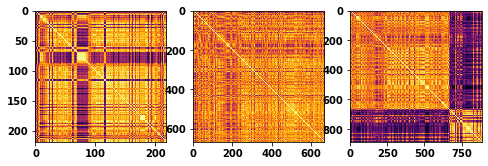

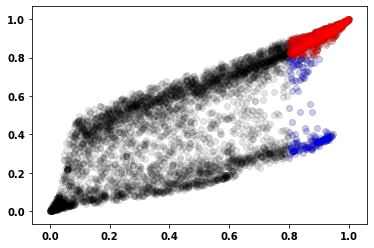

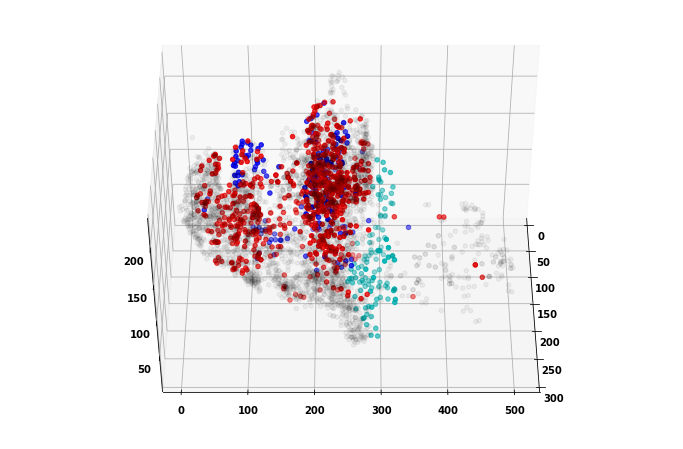

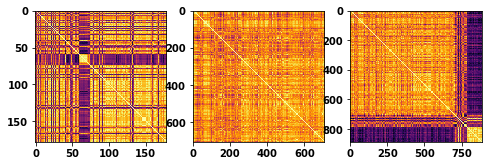

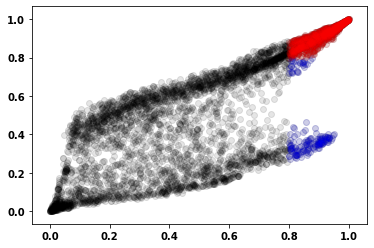

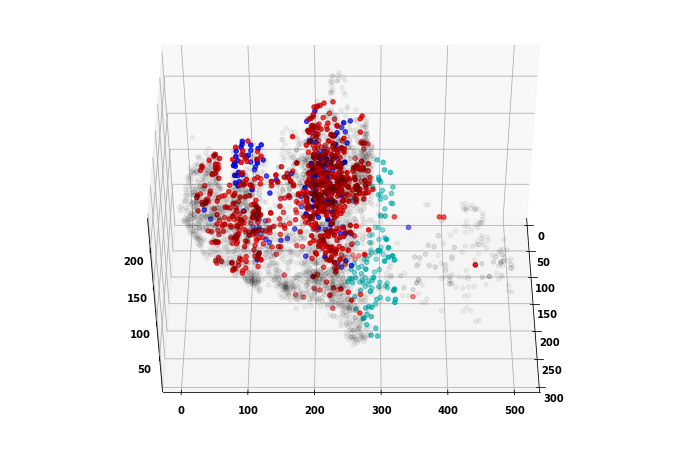

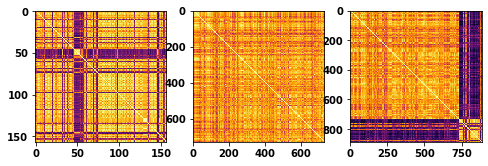

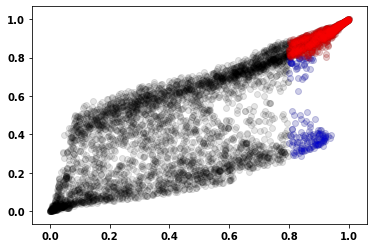

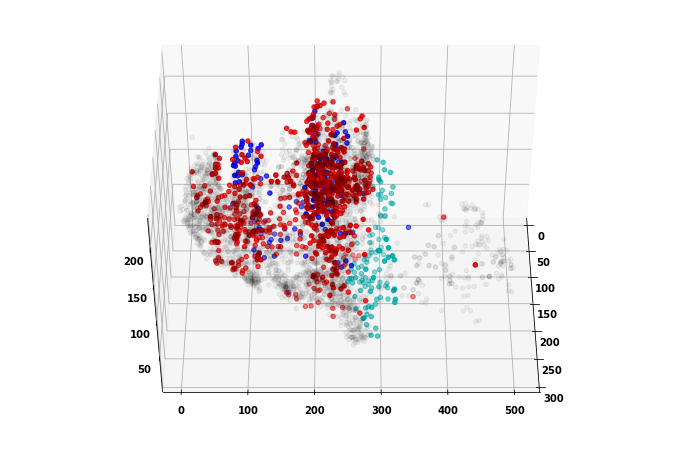

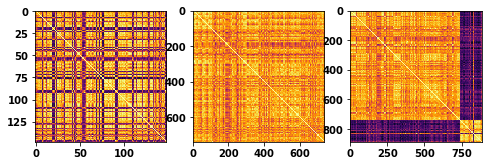

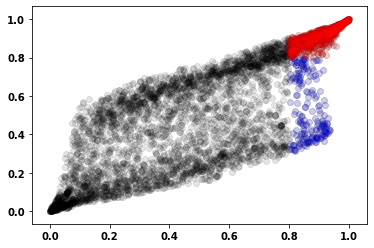

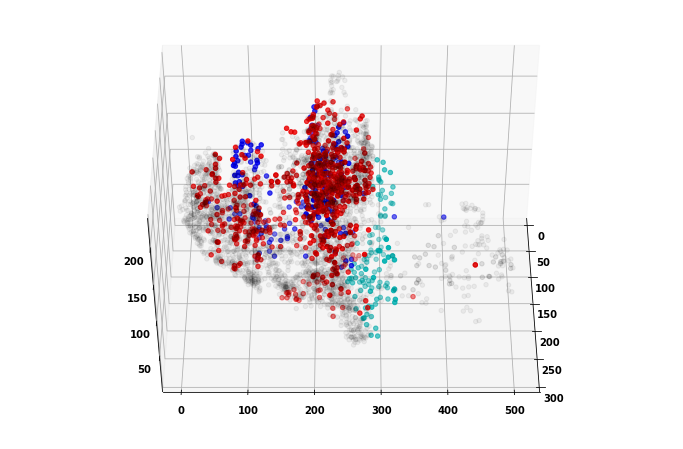

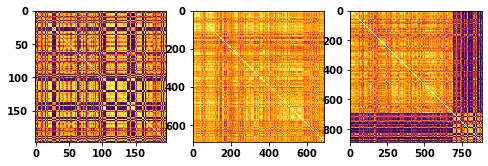

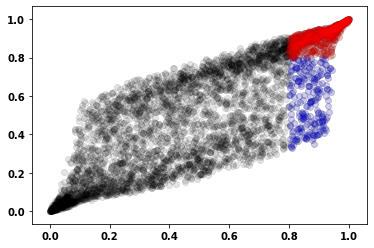

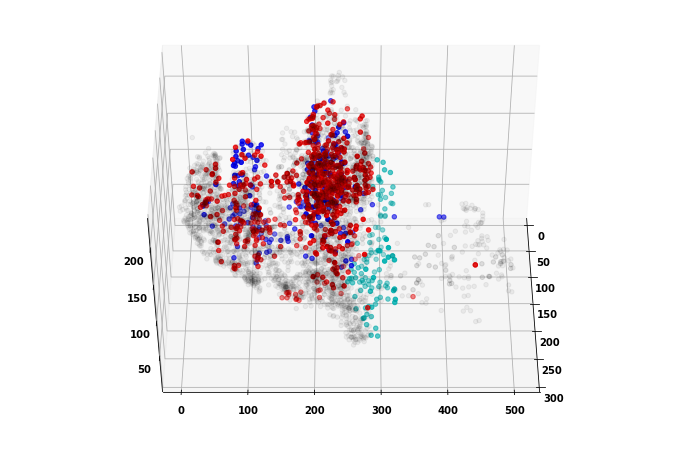

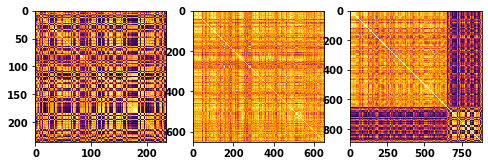

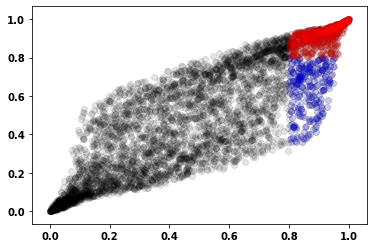

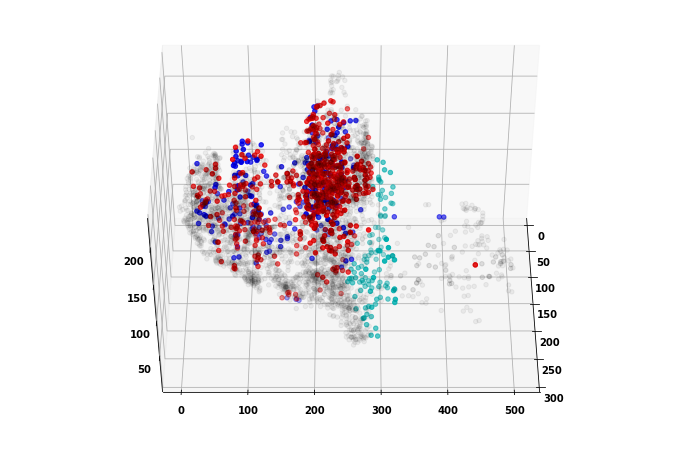

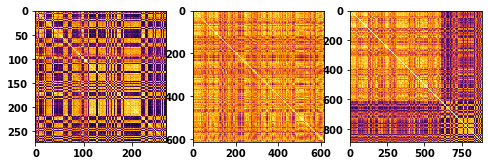

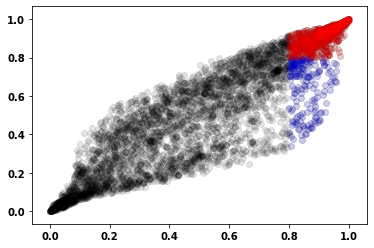

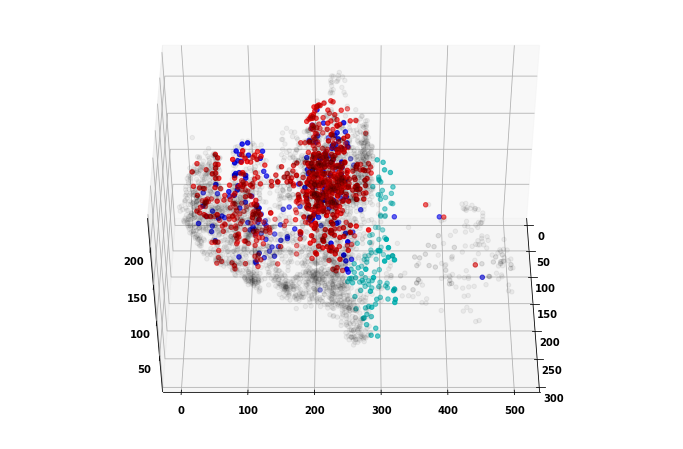

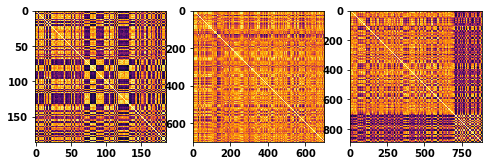

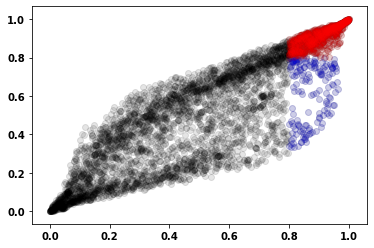

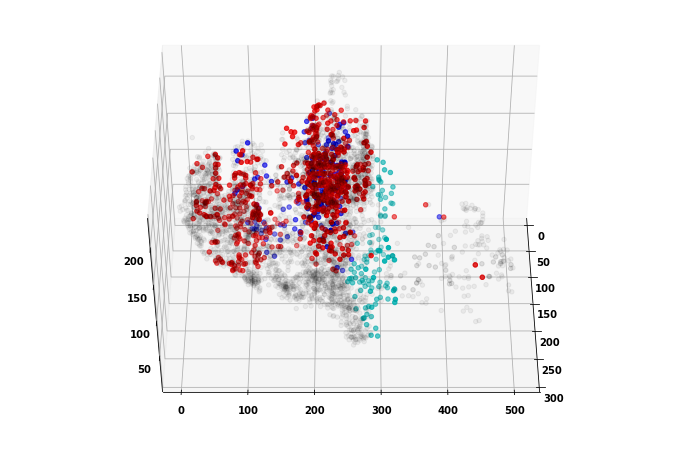

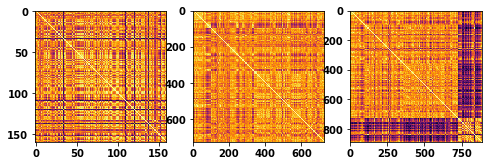

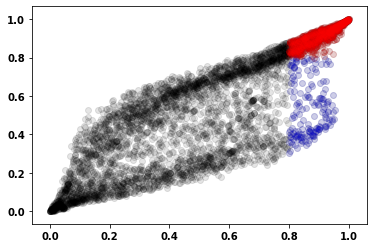

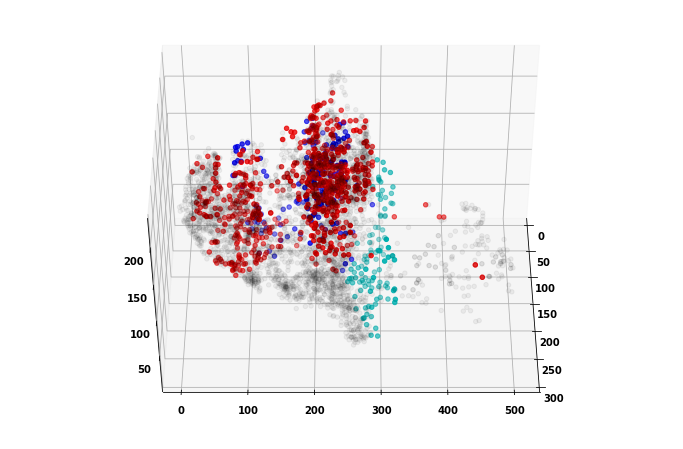

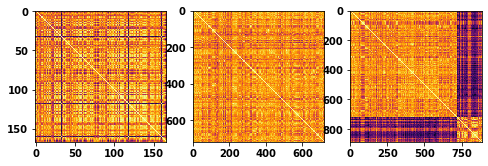

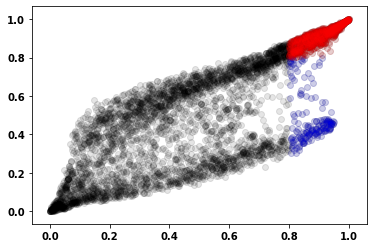

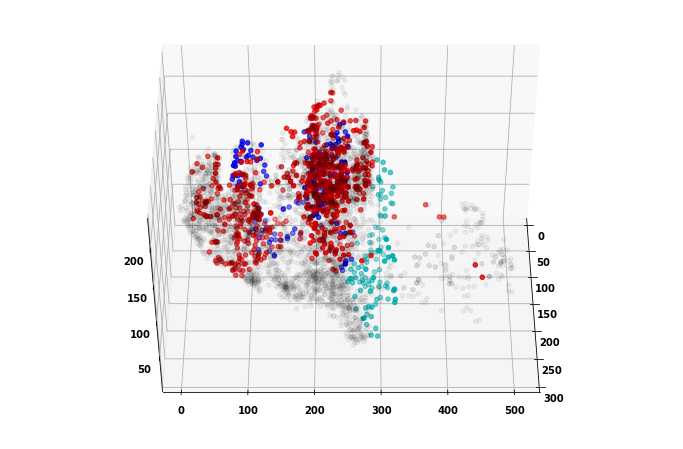

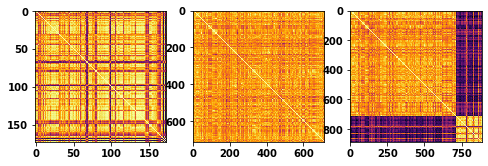

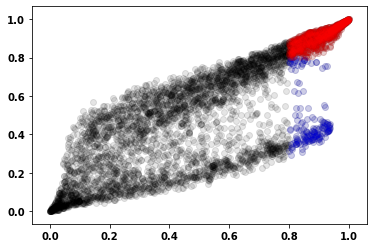

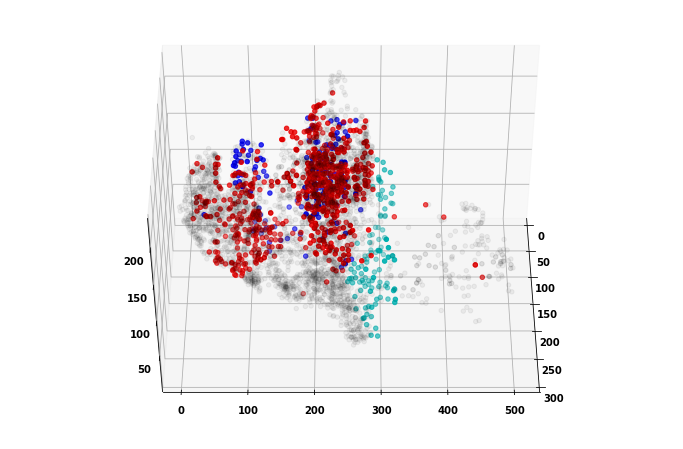

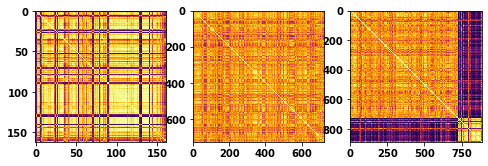

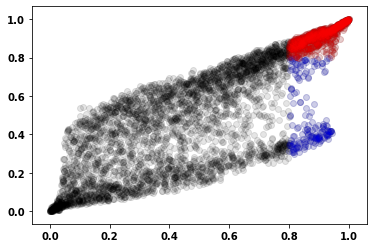

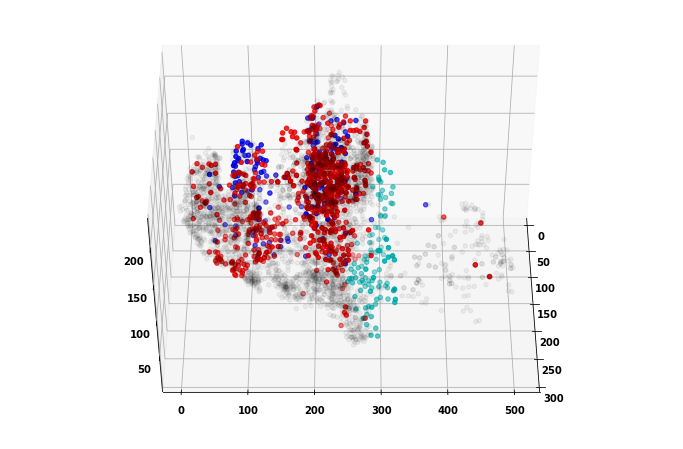

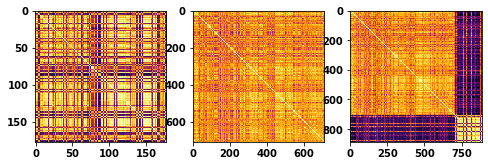

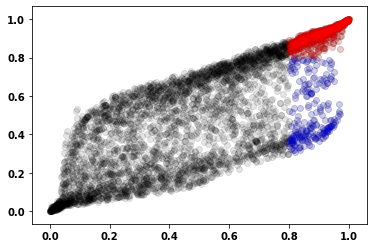

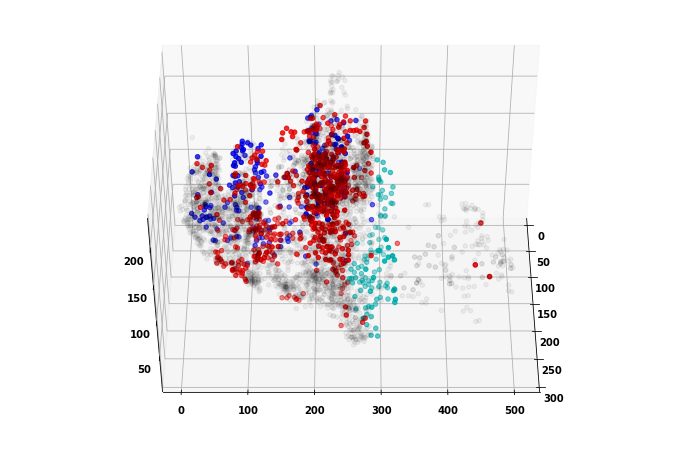

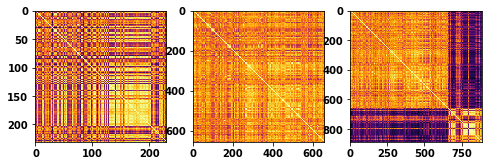

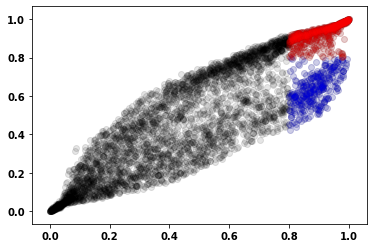

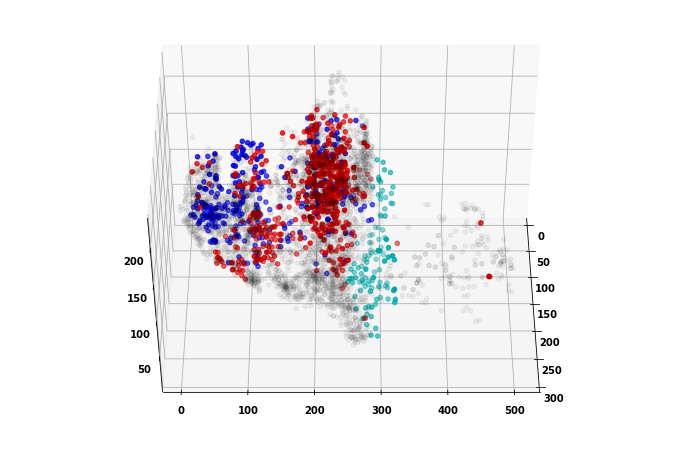

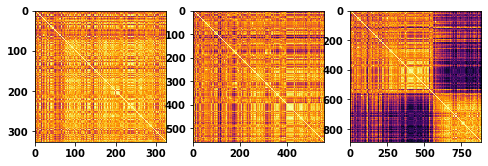

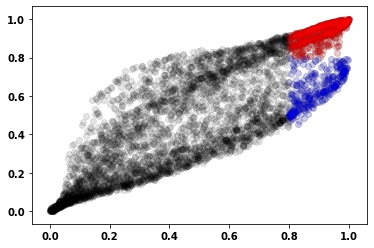

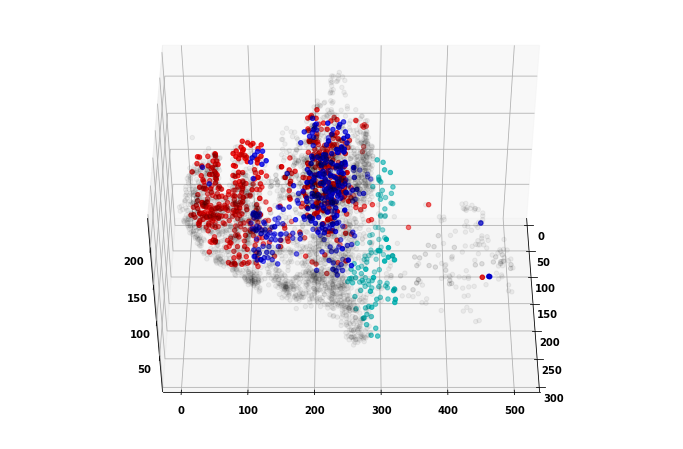

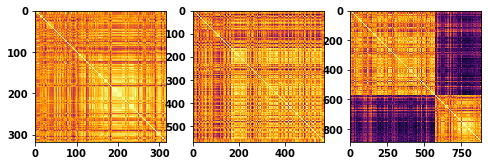

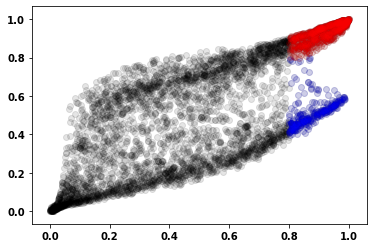

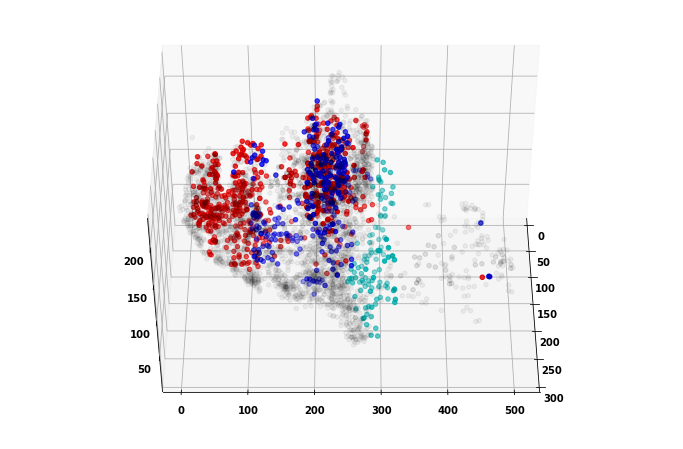

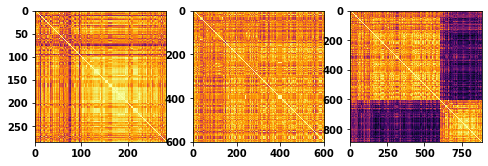

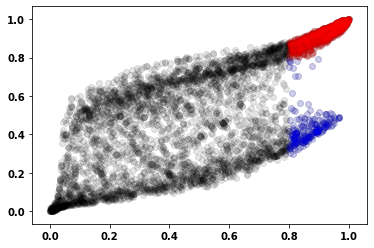

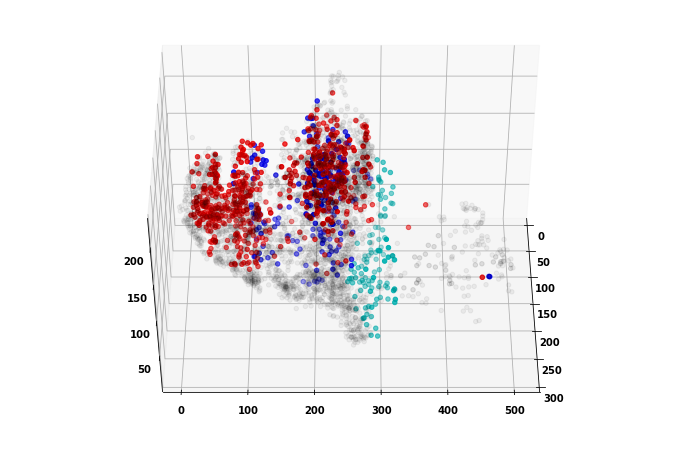

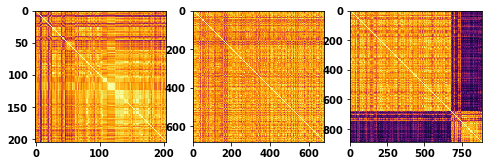

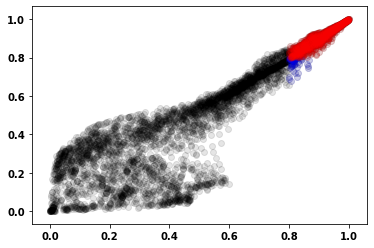

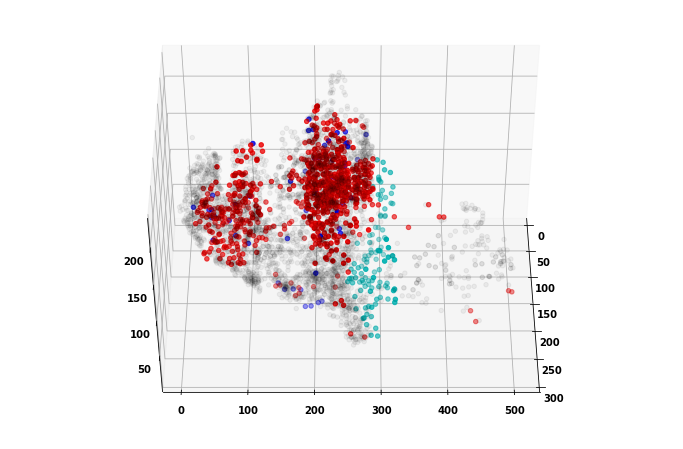

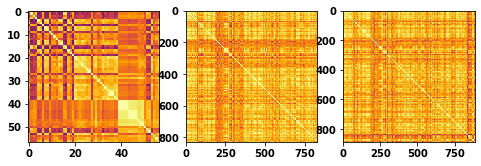

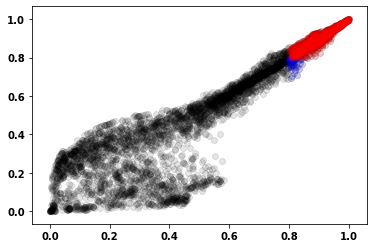

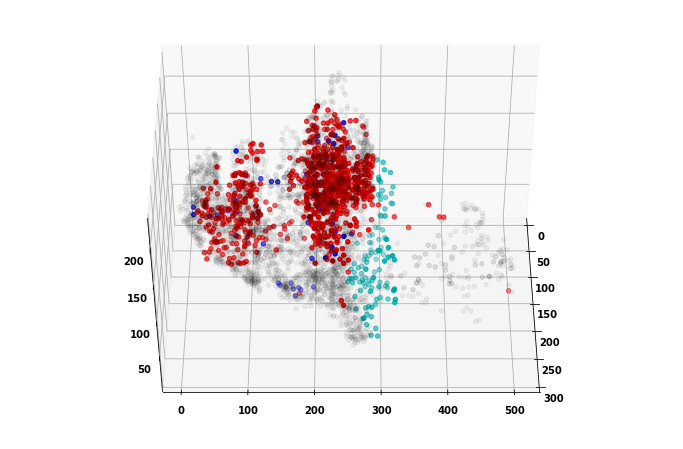

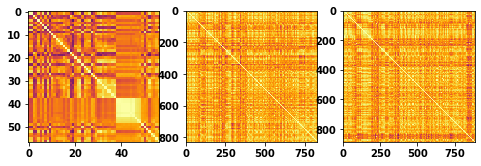

In [64]:
%matplotlib inline

cut = 0.80
#for idx in range(sz_start_idx-110, sz_start_idx-110+1):
for idx in range(200,400,10):
    d, e = dynamic_degree_centrality_percentile[idx], dynamic_eigenvector_centrality_percentile[idx]
    hubs = np.where((d>cut)&(e<=cut))[0]
    shubs = np.where((d>cut) & (e>cut))[0]
    
    plt.figure()
    plt.scatter(d,e,color='k',alpha=0.1)
    plt.scatter(d[hubs],e[hubs],color='b',alpha=0.1)
    plt.scatter(d[shubs],e[shubs],color='r',alpha=0.1)
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*coords.T, color='k', alpha=0.05)
    ax.scatter(*coords[hubs,:].T, color='b')
    ax.scatter(*coords[shubs,:].T, color='r')
    ax.scatter(*cerebellum_spatial_coords.T, color='c')
#     ax.scatter(*dthalamus_spatial_coords.T, color='g')
#     ax.scatter(*vthalamus_spatial_coords.T, color='g')   
    ax.view_init(45,0)
    plt.show()

    
    r = np.random.randint(traces.shape[0], size=(len(shubs),))
    straces = (traces[shubs,idx:idx+120])
    htraces = (traces[hubs,idx:idx+120])
    stacked_traces = np.concatenate((straces, htraces))
    
    Sh = S[hubs,:]; Sh = Sh[:,hubs]
    Ss = S[shubs,:]; Ss = Ss[:,shubs]
    
#     fig, ax = plt.subplots(2,1)
#     ax[0].plot(straces[:,:].T, color='r', alpha=0.05)
#     ax[1].plot(htraces[:,:].T, color='k', alpha=0.05)
#     plt.show()
    
    fig, ax= plt.subplots(1,3, figsize=(8,8))
    ax[0].imshow(np.corrcoef(htraces), cmap='inferno', vmin=-1., vmax=1.)
    ax[1].imshow(np.corrcoef(straces), cmap='inferno', vmin=-1., vmax=1.)
    ax[2].imshow(np.corrcoef(stacked_traces), cmap='inferno', vmin=-1., vmax=1.)
    plt.show()

In [4]:
# def get_ev(A):
#     import scipy as sp
#     from scipy import sparse
#     from scipy.sparse import linalg

#     #A = np.triu(A)
#     M = sparse.coo_matrix(A, dtype='float32')
#     eigenvalue, eigenvector = linalg.eigs(M.T, k=1, which="LR", maxiter=50, tol=1e-3)
#     largest = eigenvector.flatten().real
#     norm = np.sign(largest.sum()) * sp.linalg.norm(largest)
#     return largest / norm
%matplotlib auto
from copy import deepcopy
Ss = deepcopy(S)
Ss[np.where(Ss >= 1)] = 0
Sw = np.sum(Ss, axis=0)
#Sw = get_ev(S)
Stop = np.where(Sw > np.percentile(Sw, 90))[0]

plt.figure()
plt.imshow(Ss, cmap='inferno')
plt.show()

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.scatter(*coords.T, color='k', alpha=0.05)
ax.scatter(*coords[Stop,:].T, color='r')
ax.scatter(*habenula_spatial_coords.T, color='g')
ax.view_init(45,0)
plt.show()


Using matplotlib backend: Qt5Agg


Using matplotlib backend: Qt5Agg
4841


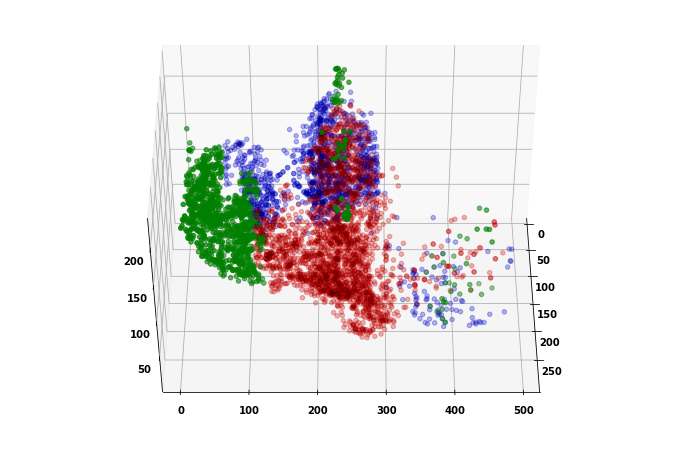

In [158]:
from copy import deepcopy
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

Z = sch.linkage(S, method='ward', metric='euclidean')
inds   = sch.fcluster(Z, 3, 'maxclust')

%matplotlib auto
import matplotlib.cm as cm

colors = cm.Dark2(np.linspace(0,1,8))

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
print(len(inds))
ax.scatter(*coords.T, color='k', alpha=0.05)
#for (i, ind) in enumerate(set(inds)):
ax.scatter(*coords[np.where(inds==1)[0],:].T, color='r', alpha=0.25)
ax.scatter(*coords[np.where(inds==2)[0],:].T, color='b', alpha=0.25)
ax.scatter(*coords[np.where(inds==3)[0],:].T, color='g')
#ax.scatter(*coords[np.where(inds==4)[0],:].T, color='m')
#ax.scatter(*dthalamus_spatial_coords.T, color='g')
#ax.scatter(*vthalamus_spatial_coords.T, color='g')

ax.view_init(45,0)
plt.show()

In [159]:
cut=0.80
raster = []
for i in range(2380):
    d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
    hubs = np.where((d>cut))[0]
    shubs = np.where((e>cut) & (d>cut))[0] 
    
    sl = np.zeros(len(d), dtype='uint8')
    sl[shubs] = 1
    raster.append(sl)
    
raster = np.asarray(raster, dtype='uint8')

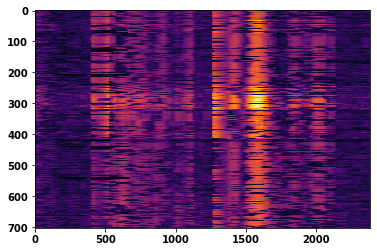

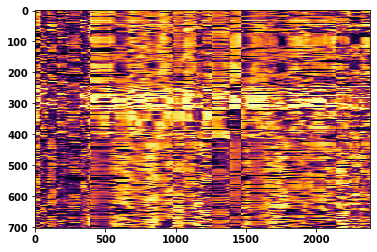

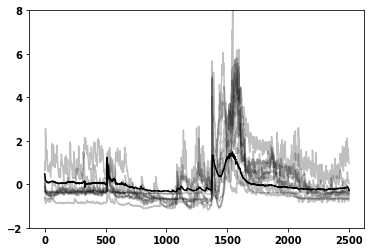

In [164]:
%matplotlib inline
plt.figure()
plt.imshow(dynamic_degree_centrality[:,valid_idxs[top_jumps]].T, cmap='inferno', aspect='auto')
plt.show()

plt.figure()
plt.imshow(dynamic_eigenvector_centrality_percentile[:,valid_idxs[top_jumps]].T, cmap='inferno', aspect='auto', vmin=0., vmax=1.)
plt.show()

plt.figure()
plt.plot(traces[valid_idxs[top_jumps][20:30],:].T, color='k', alpha=0.25)
plt.plot(np.mean(traces,axis=0), color='k')
plt.ylim([-2,8])
plt.show()


Using matplotlib backend: Qt5Agg


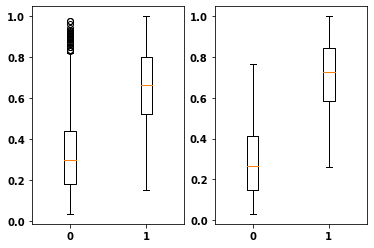

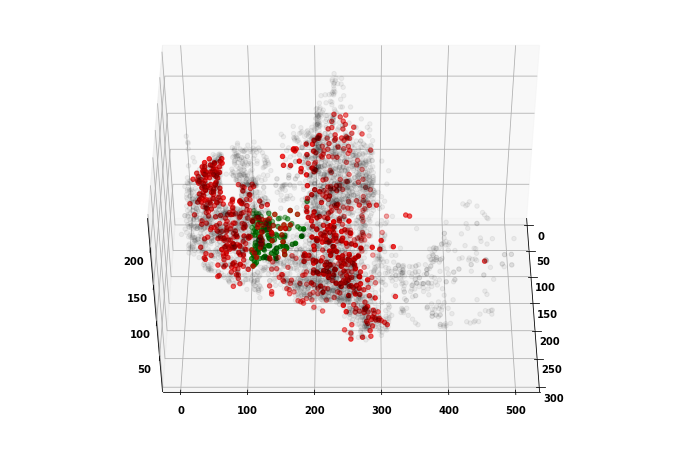

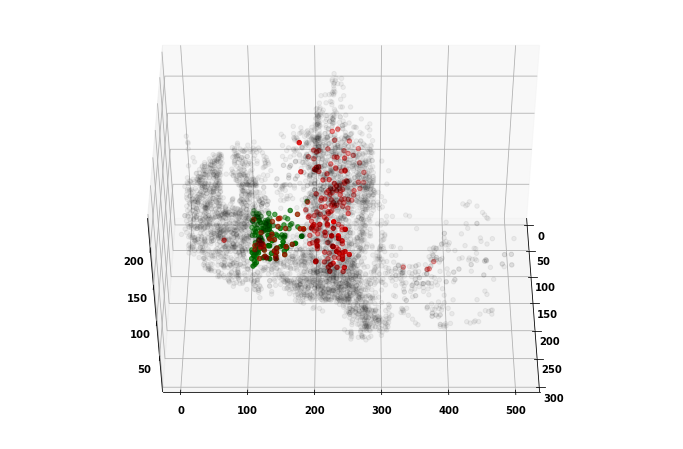

In [170]:
%matplotlib auto

d, e = dynamic_degree_centrality, dynamic_eigenvector_centrality
valid_idxs = list(np.where(inds == 1)[0]) + list(np.where(inds == 3)[0])
valid_idxs = np.asarray(valid_idxs)

dbaseline, ebaseline = np.mean(d[:360,:], axis=0), np.mean(e[:360, :], axis=0)
dpresz, epresz       = np.mean(d[620:sz_start_idx-120,:],axis=0), np.mean(e[620:sz_start_idx-120,:],axis=0)

baseline_degree_p = data2percentile(dbaseline)[valid_idxs]
presz_degree_p    = data2percentile(dpresz)[valid_idxs]
jump = (presz_degree_p - baseline_degree_p)
top_jumps = np.where(jump > np.percentile(jump, 80))[0]

baseline_e_p = data2percentile(ebaseline)[valid_idxs]
presz_e_p    = data2percentile(epresz)[valid_idxs]
jump = (presz_e_p - baseline_e_p)
top_jumps = np.where(jump > np.percentile(jump, 80))[0]

fig, ax = plt.subplots(1,2)
ax[0].boxplot([baseline_degree_p[top_jumps], presz_degree_p[top_jumps]], positions=[0,1])
ax[1].boxplot([baseline_e_p[top_jumps], presz_e_p[top_jumps]], positions=[0,1])

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter(*coords.T, color='k', alpha=0.05)
ax.scatter(*coords[valid_idxs[top_jumps],:].T, color='r')
ax.scatter(*dthalamus_spatial_coords.T, color='g')
ax.scatter(*vthalamus_spatial_coords.T, color='g')
ax.view_init(45,0)
plt.show()

raster_mean = np.mean(raster[620:sz_start_idx-120,:], axis=0)
mean_cutoff = np.percentile(raster_mean, 90.)
temporal_idxs = np.where(raster_mean > mean_cutoff)[0]
temporal_idxs = list(set(temporal_idxs) - set(np.where(inds == 2)[0]))

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter(*coords.T, color='k', alpha=0.05)
ax.scatter(*coords[temporal_idxs,:].T, color='r')
ax.scatter(*dthalamus_spatial_coords.T, color='g')
ax.scatter(*vthalamus_spatial_coords.T, color='g')
ax.view_init(45,0)
plt.show()

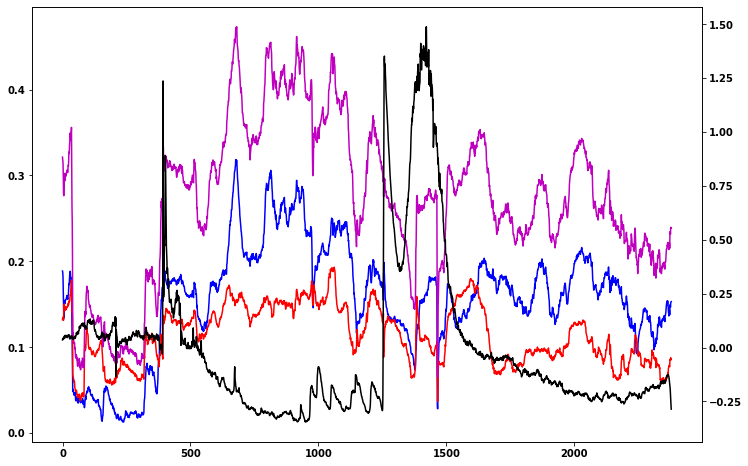

0.7932482508084963 0.5567597161048665


In [166]:
%matplotlib inline
injump, inhub, thubs = [], [], []
for t in range(raster.shape[0]):
    sl = raster[t,:]
    arehubs = np.where(sl == 1)[0]
    
    injump.append(len(set(valid_idxs[top_jumps])&set(arehubs)) / float(len(arehubs)))
    inhub.append(len(set(temporal_idxs)&set(arehubs)) / float(len(arehubs)))
    thubs.append(injump[-1] + inhub[-1])
    
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(injump, color='b')
ax.plot(inhub, color='r')
ax.plot(thubs, color='m')
ax2 = ax.twinx()
ax2.plot(np.mean(traces,axis=0)[120:], color='k')
plt.show()

before_corr = np.corrcoef(injump[:360], inhub[:360])[0,1]
after_corr  = np.corrcoef(injump[sz_start_idx-120-360:sz_start_idx-120], inhub[sz_start_idx-120-360:sz_start_idx-120])[0,1]
print(before_corr, after_corr)


In [14]:

zone1, zone2 = [], []
cut = 0.80
for i in range(2380):
    d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
    hubs = np.where((d>cut) & (e<=cut))[0]
    shubs = np.where((e>cut) & (d>cut))[0] 
    
    z1 = np.where(inds == 1)[0]
    z1_overlap = set(shubs) & set(z1)
    z2 = np.where(inds == 2)[0]
    z2_overlap = set(shubs) & set(z2)
    

    zone1.append(len(z1_overlap))
    zone2.append(len(z2_overlap))
    

raster_mean = np.mean(raster, axis=0)
mean_cutoff = np.percentile(raster_mean, 80.)
print(mean_cutoff)
valid_idxs = np.asarray(np.where(raster_mean > mean_cutoff)[0])
zone1, zone2 = np.asarray(zone1), np.asarray(zone2)

fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(zone1/float(len(np.where(inds==1)[0])), color='r')
ax[0].plot(zone2/float(len(np.where(inds==2)[0])), color='b')
#ax0 = ax[0].twinx()
#ax0.plot(dynamic_ev_deg_correlation, color='k')
ax[0].set_xticks([])
pre_corr = np.corrcoef(zone1[sz_start_idx-120-360:sz_start_idx-120],zone2[sz_start_idx-120-360:sz_start_idx-120])[0,1]
init_corr  = np.corrcoef(zone1[:360], zone2[:360])[0,1]
full_corr = np.corrcoef(zone1, zone2)[0,1]
ax[0].set_title('%0.3f, %0.3f, %0.3f' % (init_corr, pre_corr, full_corr))

ax[1].plot(np.mean(traces,axis=0)[120:], color='k')
plt.show()

# plt.figure(figsize=(12,8))
# plt.imshow(raster.T,cmap='gray')
# plt.show()


fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter(*coords.T, color='k', alpha=0.05)
ax.scatter(*coords[valid_idxs,:].T, color='r')
ax.scatter(*dthalamus_spatial_coords.T, color='g')
ax.scatter(*vthalamus_spatial_coords.T, color='g')

ax.view_init(90,0)
plt.show()

0.059243697478991594


In [220]:
th_active = []
cut = 0.80
raster = []
for i in range(2380):
    d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
    hubs = np.where((d>cut))[0]
    shubs = np.where((e>cut) & (d>cut))[0] 
    th_active.append(len(set(hubs) & set(valid_idxs)) / float(len(hubs)))
    
    

fig, ax = plt.subplots()
ax.plot(th_active, color='r')
ax2 = ax.twinx()
#ax2.plot(dynamic_ev_deg_correlation, color='k')
ax2.plot(np.mean(traces,axis=0)[120:], color='k')
ax.set_title(np.corrcoef(th_active, dynamic_ev_deg_correlation)[0,1])
plt.show()

In [38]:
from graph_utils import leiden_clustering


gt_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f2-weighted/gt/fc-150.npz'
f = np.load(gt_filepath)
fc = f['fc'].astype('float32')
# f.close()
# fc[np.where(fc<0.0)] = 0
# _, mod = leiden_clustering(fc, directed=False, part=inds)
# print(mod)

plt.figure()
plt.imshow(fc, cmap='inferno', vmin=-1., vmax=1.)
plt.show()
